# 0. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report

import os
import glob as gl

# 1. Data import and preprocessing

In [2]:
DATASET_PATH="/kaggle/input/chest-xray-covid19-pneumonia/Data"
TRAIN_PATH="/kaggle/input/chest-xray-covid19-pneumonia/Data/train"
TEST_PATH="/kaggle/input/chest-xray-covid19-pneumonia/Data/test"

This code cell walks through the dataset folder and shows how many subfolders and image files are in each directory, giving a quick look at how the dataset is organized.

In [3]:
print('Dataset Summary')
print("============================\n")
for dirpath,dirnames,filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n============================')

Dataset Summary

There are 2 directories and 0 images in /kaggle/input/chest-xray-covid19-pneumonia/Data
There are 3 directories and 0 images in /kaggle/input/chest-xray-covid19-pneumonia/Data/test
There are 0 directories and 855 images in /kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA
There are 0 directories and 317 images in /kaggle/input/chest-xray-covid19-pneumonia/Data/test/NORMAL
There are 0 directories and 116 images in /kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19
There are 3 directories and 0 images in /kaggle/input/chest-xray-covid19-pneumonia/Data/train
There are 0 directories and 3418 images in /kaggle/input/chest-xray-covid19-pneumonia/Data/train/PNEUMONIA
There are 0 directories and 1266 images in /kaggle/input/chest-xray-covid19-pneumonia/Data/train/NORMAL
There are 0 directories and 460 images in /kaggle/input/chest-xray-covid19-pneumonia/Data/train/COVID19



In [4]:
# Getting tain and test images
train_images= gl.glob(f'{TRAIN_PATH}/**/*.jpg')
test_images= gl.glob(f'{TEST_PATH}/**/*.jpg')
# /kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19/COVID19(460).jpg

In [5]:
train_images[0]

'/kaggle/input/chest-xray-covid19-pneumonia/Data/train/PNEUMONIA/PNEUMONIA(3189).jpg'

In [6]:
# Size of train and test sets
print("Total number of training examples: ", len(train_images))
print("Total number of test examples: ", len(test_images))

Total number of training examples:  5144
Total number of test examples:  1288


In [7]:
test_images[0].split('/')

['',
 'kaggle',
 'input',
 'chest-xray-covid19-pneumonia',
 'Data',
 'test',
 'PNEUMONIA',
 'PNEUMONIA(3607).jpg']

In [8]:
test_images[0].split('/')[-2]

'PNEUMONIA'

### Label Generation and DataFrame Creation

- `generate_labels()` takes a list of image paths and extracts the label (the parent folder name) for each image.
- `build_df()` creates a DataFrame with image paths, corresponding labels, and a numerical label encoding (`NORMAL` = 1, `COVID19` = 2, and others = 3). This helps in organizing the dataset for model training.


In [9]:
def generate_labels(image_paths):
    return[_.split('/')[-2:][0] for _ in image_paths]

def build_df(image_paths,labels):
    
    #Creating the dataframe
    df=pd.DataFrame({
        'image_path':image_paths,
        'label':generate_labels(labels)
    })
    
    #generate label encoding
    df['label_encoded'] = df['label'].apply(lambda label_encoded: 1 if label_encoded == 'NORMAL' else (2 if label_encoded == 'COVID19' else 3) )

    return df

In [10]:
train_df = build_df(train_images,generate_labels(train_images))
test_df = build_df(test_images,generate_labels(test_images))

In [11]:
train_df.label.value_counts()

label
PNEUMONIA    3418
NORMAL       1266
COVID19       460
Name: count, dtype: int64

In [12]:
test_df.label.value_counts()

label
PNEUMONIA    855
NORMAL       317
COVID19      116
Name: count, dtype: int64

In [13]:
train_df.sample(10)

,image_path,label,label_encoded
3688,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL,1
4213,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL,1
3633,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL,1
1130,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,3
2051,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,3
4340,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL,1
821,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,3
3799,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL,1
454,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,3
3836,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL,1


In [14]:
test_df.sample(10)

,image_path,label,label_encoded
1031,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL,1
266,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,3
936,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL,1
510,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,3
1050,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL,1
414,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,3
1216,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,COVID19,2
665,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,3
1058,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,NORMAL,1
228,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA,3


### Loading and Displaying an Image

- First, we define `load_image()` to read an image file from a given `image_path` using TensorFlow.
- Now, let's print the label of the image at index 5 from the `train_df`.
- Next, we load and display the image at that same index to visualize it and check its content.


In [15]:
def load_image(image_path):
    # Read image file from the image_path
    image=tf.io.read_file(image_path)
    
    # Return image
    return image

In [16]:
train_df.image_path[5]

'/kaggle/input/chest-xray-covid19-pneumonia/Data/train/PNEUMONIA/PNEUMONIA(2307).jpg'

Image Label:  PNEUMONIA


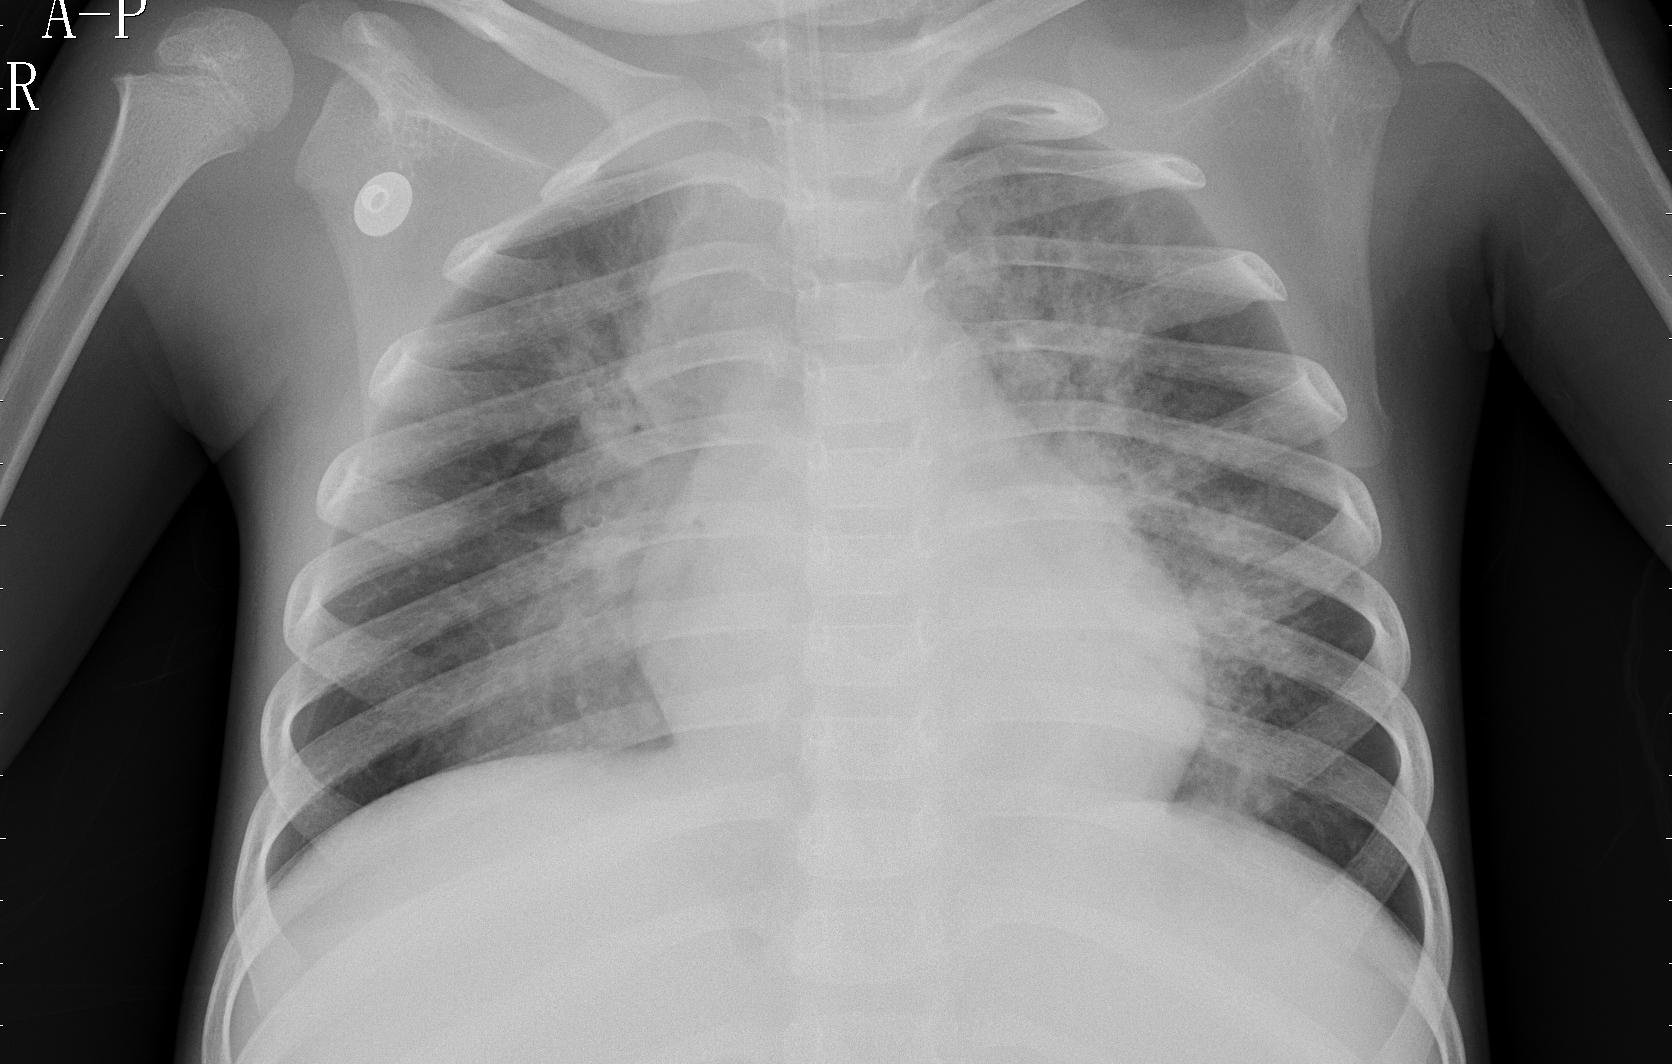

In [17]:
print("Image Label: ", train_df.label[5])
load_img(train_df.image_path[5])

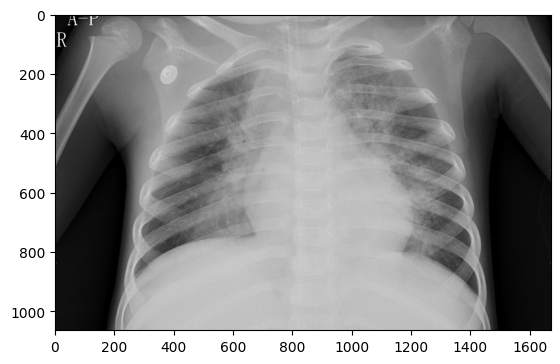

In [18]:
random_image = load_img(train_df.image_path[5])
plt.imshow(random_image)

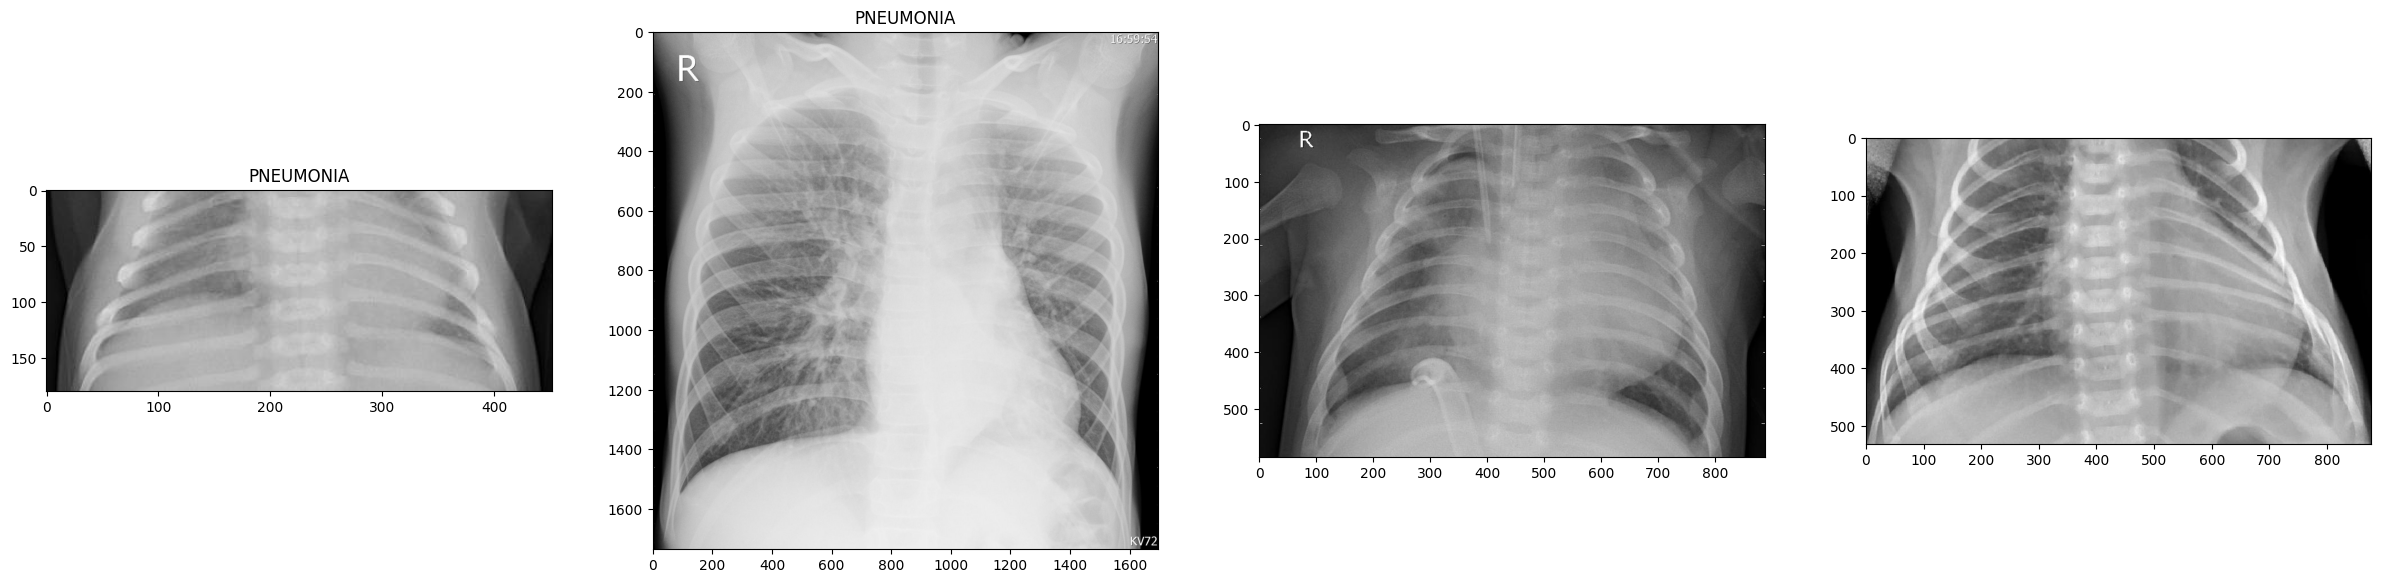

In [19]:
# Plotting/Showing the figures
plt.figure(figsize=(30,20))
plt.subplot(1,4,1)
random_image = load_img(train_df.image_path[10])
plt.imshow(random_image)
plt.title(train_df.label[10])
plt.subplot(1,4,2)
random_image = load_img(train_df.image_path[291])
plt.imshow(random_image)
plt.title(train_df.label[10])

plt.subplot(1,4,3)
random_image = load_img(train_df.image_path[29])
plt.imshow(random_image)
plt.subplot(1,4,4)
random_image = load_img(train_df.image_path[299])
plt.imshow(random_image)

# 2. Model Development 

In [20]:
train_data_dir = TRAIN_PATH
test_data_dir = TEST_PATH

### Setting Up Data Generators with Augmentation

- We're defining `train_datagen` and `test_datagen` as `ImageDataGenerator()` objects for data augmentation during training and testing. 
- Now, we set up the `train_generator` and `test_generator` to load images from the training and testing directories, respectively.
- Images will be resized to 224x224, and the data will be fed in batches of 32 for both training and testing.


In [21]:
# Defining data generators with data augmentation for training
train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


### Building the CNN Model

- First, we initialize a `Sequential` model to stack layers.
- For **feature extraction**, we add three convolutional layers (`Conv2D`) with increasing filter sizes (32, 64, and 128), each followed by a max-pooling layer (`MaxPooling2D`) to reduce the spatial dimensions.
- Finally, we move to the **classification** part, where we flatten the feature maps and pass them through two fully connected layers. The first dense layer has 128 units with ReLU activation, and the second has 3 units with softmax activation to output class probabilities for 3 categories.


In [22]:
# Build the CNN model
model = models.Sequential()

# Feature Extraction
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#Classification
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Training the Model

- Now, we train the model for 10 epochs using the `fit()` method.
- We use the `train_generator` for feeding training data and the `test_generator` for validation data during each epoch to monitor performance.

In [24]:
# Train the model
epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1739474307.417118     172 service.cc:145] XLA service 0x7ae628007d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739474307.417174     172 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1739474307.417178     172 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/161 ━━━━━━━━━━━━━━━━━━━━ 30:13 11s/step - accuracy: 0.0625 - loss: 25.4750

I0000 00:00:1739474312.850157     172 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/161 ━━━━━━━━━━━━━━━━━━━━ 133s 758ms/step - accuracy: 0.7471 - loss: 33.7496 - val_accuracy: 0.8936 - val_loss: 0.2671
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 65s 388ms/step - accuracy: 0.8818 - loss: 0.3357 - val_accuracy: 0.9255 - val_loss: 0.2128
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 65s 391ms/step - accuracy: 0.9115 - loss: 0.2695 - val_accuracy: 0.8447 - val_loss: 0.4139
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 385ms/step - accuracy: 0.9126 - loss: 0.2498 - val_accuracy: 0.8812 - val_loss: 0.3229
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 65s 390ms/step - accuracy: 0.9564 - loss: 0.1361 - val_accuracy: 0.9394 - val_loss: 0.2588
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 65s 389ms/step - accuracy: 0.9613 - loss: 0.1089 - val_accuracy: 0.9084 - val_loss: 0.3228
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 386ms/step - accuracy: 0.9607 - loss: 0.1043 - val_accuracy: 0.9037 - val_loss: 0.3442
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 66s 395ms/step - accuracy: 0.9757 - loss: 0.0682 - v

### Evaluating the Model

- After training, we evaluate the model on the test data using the `evaluate()` method.
- We calculate the test loss and accuracy by running the model on the `test_generator` with the specified batch size.
- The printed test accuracy shows how well the model performs on unseen data.

In [25]:
# Evaluating the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_acc}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 323ms/step - accuracy: 0.9257 - loss: 0.3063
Test Accuracy: 0.921093761920929


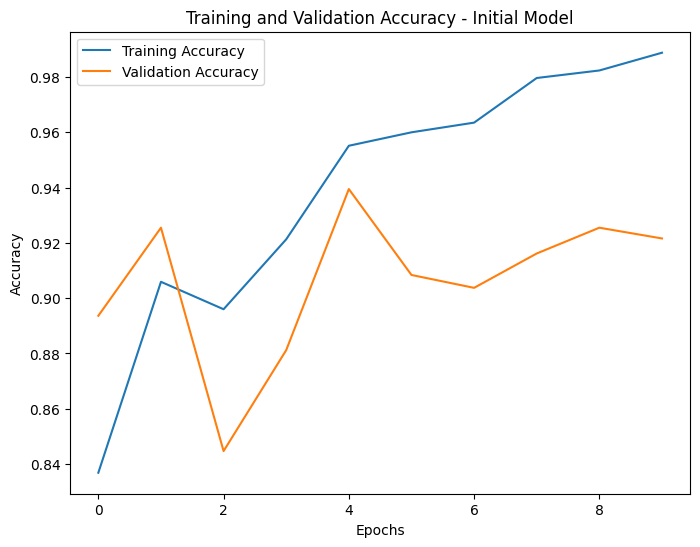

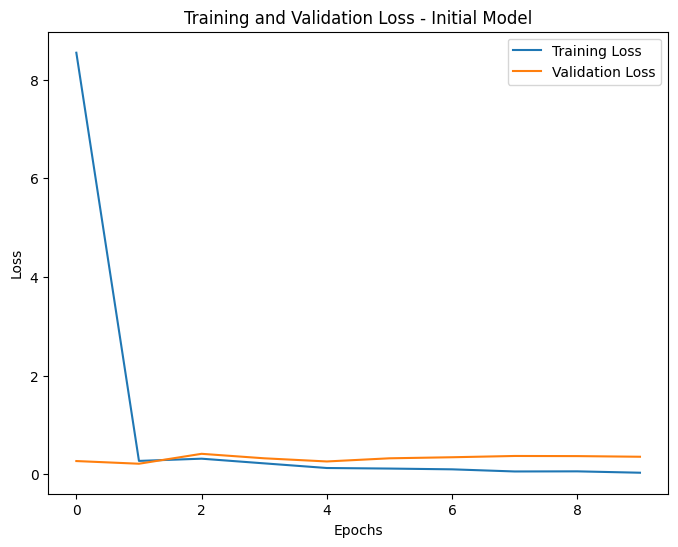

In [33]:
# Plotting the training and validation accuracy for the initial model
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy - Initial Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss for the initial model
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - Initial Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Confusion Matrix and Classification Report
This section evaluates the model's performance using a **Confusion Matrix** and a **Classification Report**.

- **Predictions**: The model's predictions are obtained using `model.predict()`, and the predicted class labels are extracted using `argmax`.
  
- **Confusion Matrix**: The confusion matrix is plotted using Seaborn to visualize the model's performance, showing correct and incorrect predictions for each class.

- **Classification Report**: The classification report provides precision, recall, and F1-score for each class, helping to assess the model's ability to classify each category.

In [26]:
y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step


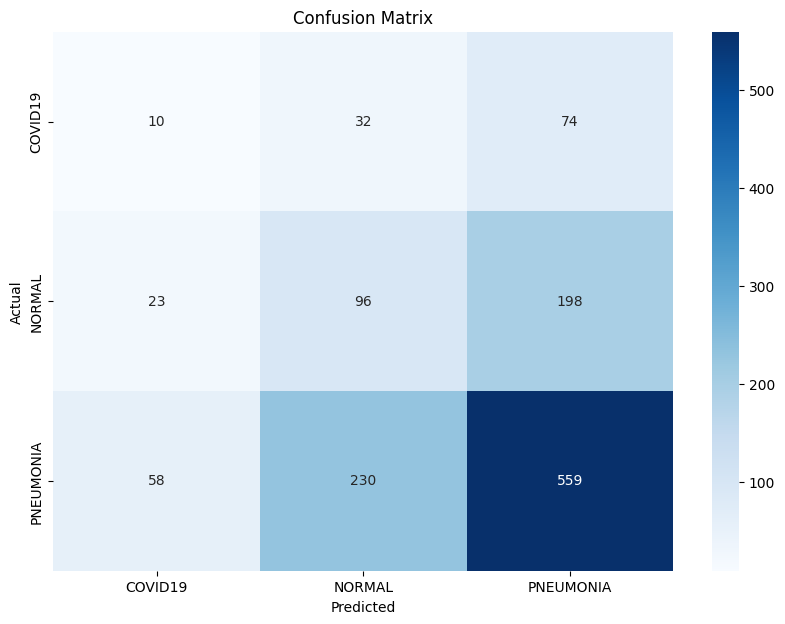

In [27]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

     COVID19       0.11      0.09      0.10       116
      NORMAL       0.27      0.30      0.28       317
   PNEUMONIA       0.67      0.66      0.67       847

    accuracy                           0.52      1280
   macro avg       0.35      0.35      0.35      1280
weighted avg       0.52      0.52      0.52      1280



# 3. Transfer Learning with Pre-Trained Models (VGG16)

In this section, we will implement **Transfer Learning** by leveraging the pre-trained **VGG16** model. VGG16 has been trained on ImageNet and can be fine-tuned to classify chest X-ray images for COVID-19 and Pneumonia detection. By using a pre-trained model, we can significantly reduce training time and improve accuracy by utilizing the learned features from ImageNet.

We will freeze the convolutional layers of VGG16 and add custom dense layers on top for classification. Let's train the model and evaluate its performance.

### Loading Pre-Trained VGG16 Model

- **Load VGG16**: We load the VGG16 model with ImageNet weights and exclude the fully connected layers (`include_top=False`).
- **Freeze Base Model**: We freeze the VGG16 layers (`trainable=False`) so only the custom layers we add will be trained.

In [34]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

### Training the Model

- **Architecture**: Use VGG16, pooling, dense layers (128 units, ReLU), and an output layer (3 classes, softmax).
- **Compile**: Apply Adam optimizer and categorical crossentropy loss.
- **Train**: Fit the model for 5 epochs with a batch size of 32, using the training and validation datasets.


In [35]:
model_vgg = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
history_vgg = model_vgg.fit(
    train_generator,
    epochs=5,
    batch_size=32,
    validation_data=test_generator
)

Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 410ms/step - accuracy: 0.8140 - loss: 0.7958 - val_accuracy: 0.9239 - val_loss: 0.2050
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 65s 385ms/step - accuracy: 0.9495 - loss: 0.1412 - val_accuracy: 0.9317 - val_loss: 0.1886
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 66s 396ms/step - accuracy: 0.9493 - loss: 0.1402 - val_accuracy: 0.9449 - val_loss: 0.1430
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 66s 388ms/step - accuracy: 0.9652 - loss: 0.1003 - val_accuracy: 0.9231 - val_loss: 0.1824
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 66s 393ms/step - accuracy: 0.9725 - loss: 0.0843 - val_accuracy: 0.9449 - val_loss: 0.1381


## Model Evaluation and Visualization

1. **Evaluate Model**: We evaluate the trained model on the test set to get the test accuracy.
2. **Accuracy and Loss Plots**: We plot the training and validation accuracy, as well as the training and validation loss, for the VGG16 model.
3. **Confusion Matrix**: We plot the confusion matrix to visualize the model's performance across different classes.


In [37]:
# Evaluate the model
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'VGG16 Test Accuracy: {test_acc_vgg}')


40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 325ms/step - accuracy: 0.9300 - loss: 0.1661
VGG16 Test Accuracy: 0.944531261920929


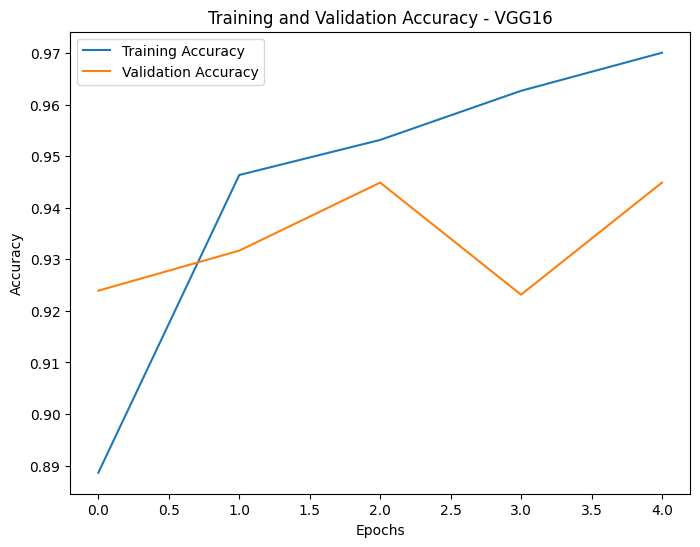

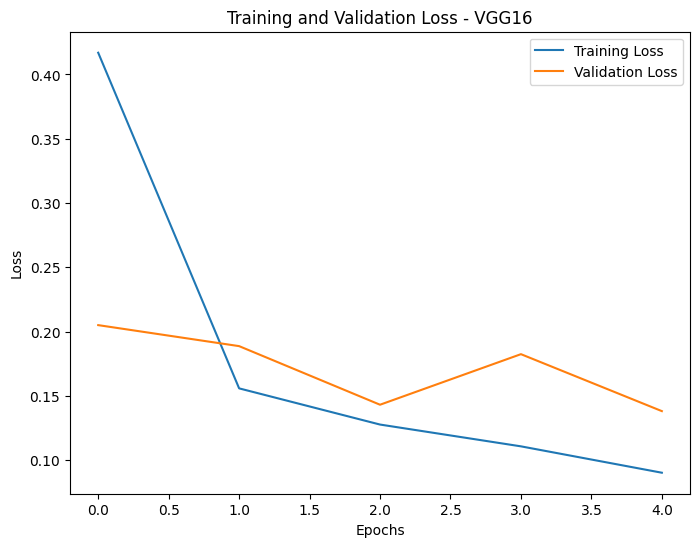

In [38]:
# Plotting the training and validation accuracy for VGG16
plt.figure(figsize=(8, 6))
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss for VGG16
plt.figure(figsize=(8, 6))
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step


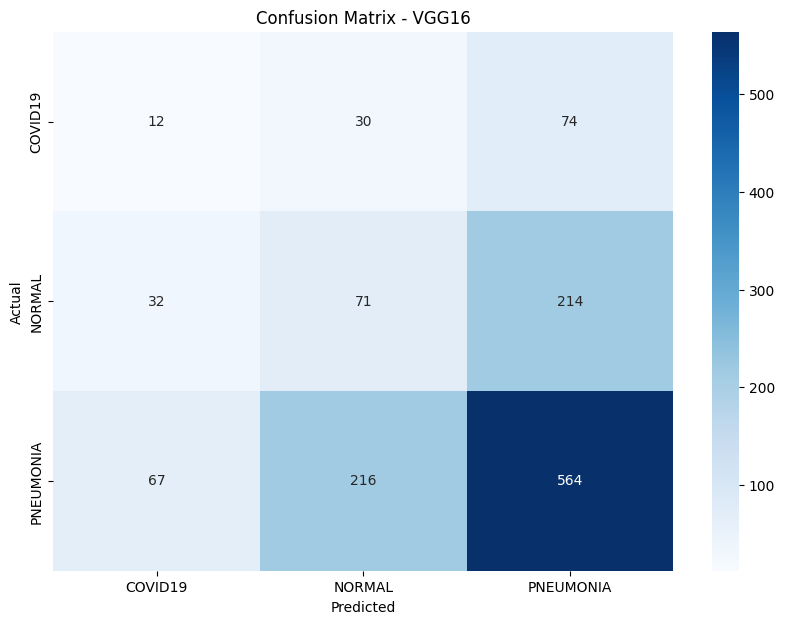

In [40]:
y_pred_vgg = model_vgg.predict(test_generator, steps=test_generator.samples // batch_size)

y_pred_classes_vgg = np.argmax(y_pred_vgg, axis=1)

y_true_vgg = test_generator.classes[:len(y_pred_classes_vgg)]

cm_vgg = confusion_matrix(y_true_vgg, y_pred_classes_vgg)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - VGG16')
plt.show()